In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('goldprice.csv', sep=';', decimal=',')
data['Month'] = pd.to_datetime(data['Month'], format='%m-%Y')
data.set_index('Month', inplace=True)

In [3]:
prices = data['Gold_Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [16]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12
X, y = create_dataset(scaled_prices, time_step)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [18]:
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(150, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
2/2 [==============================] - 0s 7ms/step - loss: 0.1849
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0863
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0175
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 11/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 12/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 13/100
2/2 [==============================] - 0s 7ms/st

In [20]:
last_12_months = scaled_prices[-time_step:].reshape(1, time_step, 1)
predictions = []
for _ in range(6):
    pred = model.predict(last_12_months)
    predictions.append(pred[0][0])
    last_12_months = np.append(last_12_months[:, 1:, :], pred.reshape(1, 1, 1), axis=1)


In [21]:
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

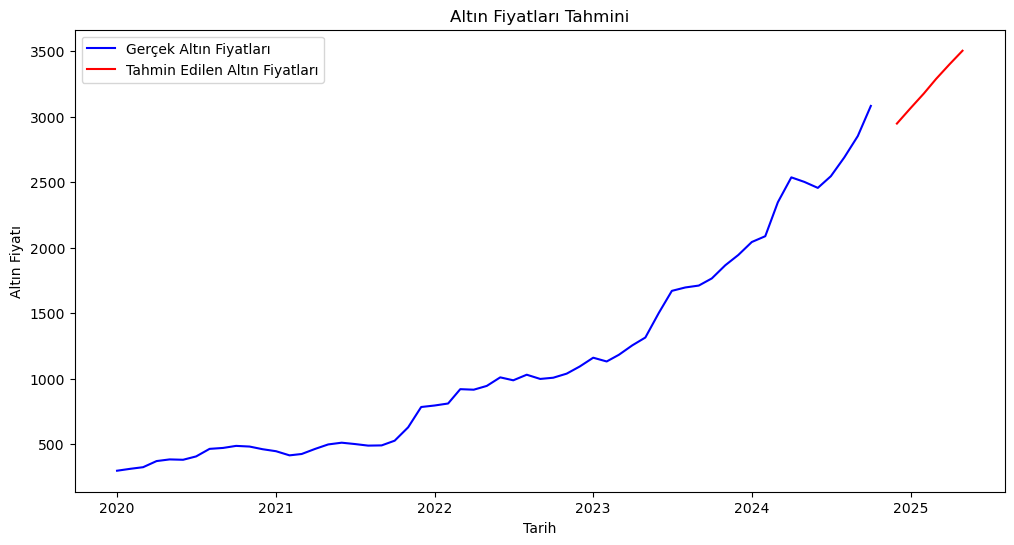

Önümüzdeki 6 ay için tahmin edilen altın fiyatları:
2024-11: 2946.88 TL
2024-12: 3063.03 TL
2025-01: 3176.24 TL
2025-02: 3286.90 TL
2025-03: 3398.92 TL
2025-04: 3502.94 TL


In [22]:
future_months = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=6, freq='M')
plt.figure(figsize=(12, 6))
plt.plot(data.index, prices, label='Gerçek Altın Fiyatları', color='blue')
plt.plot(future_months, predicted_prices, label='Tahmin Edilen Altın Fiyatları', color='red')
plt.title('Altın Fiyatları Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Altın Fiyatı')
plt.legend()
plt.show()

print("Önümüzdeki 6 ay için tahmin edilen altın fiyatları:")
for month, price in zip(future_months, predicted_prices):
    print(f"{month.strftime('%Y-%m')}: {price[0]:.2f} TL")